In [88]:
import cv2
import torch
import torchvision
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

In [89]:
TEST_IMG_PATH = "../test-video/test-img.png"
CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
VEHICLE_CLASSES = [
    'bicycle', 'car', 'motorcycle', 'bus', 'truck'
]
DETECTION_THRESHOLD = 0.4

In [90]:
def get_image_with_detections(image, boxes, classes):
   
    image = deepcopy(image)
    for class_, box in zip(classes, boxes):
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
        cv2.putText(image, class_, (int(box[0]), int(box[1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, lineType=cv2.LINE_AA)

    return image

def display_image(image):
    
    plt.figure(figsize=(15,20))
    plt.imshow(image) 
    plt.show()
    
    return

def get_vehicle_detections(VEHICLE_CLASSES, boxes, classes, labels, scores):
    
    vehicle_indices = []

    for i, class_ in enumerate(classes):
        if class_ in VEHICLE_CLASSES:
            vehicle_indices.append(i)
    
    vehicle_boxes = boxes[vehicle_indices]
    vehicle_classes = classes[vehicle_indices]
    vehicle_labels = labels[vehicle_indices]
    vehicle_scores = scores[vehicle_indices]
    
    return vehicle_boxes, vehicle_classes, vehicle_labels, vehicle_scores 

In [91]:
class Model:
    
    def __init__(self, class_names, detection_threshold, device):
        
        self.class_names = class_names
        self.detection_threshold = detection_threshold
        self.device = device
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        self.model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
        
        return
        
    def predict(self, images):
        
        inputs = []

        for image in images:
            image = self.transform(image).to(self.device)
            image = image.unsqueeze(0)
            inputs.append(image)

        inputs = torch.cat(inputs)
        self.model.eval().to(self.device)
        outputs = self.model(inputs)

        pred_classes = [self.class_names[i] for i in outputs[0]['labels'].cpu().numpy()]
        pred_scores = outputs[0]['scores'].detach().cpu().numpy()
        pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
        pred_labels = outputs[0]['labels'].cpu().numpy()
        
        threshold_mask = pred_scores >= self.detection_threshold
        
        classes = np.array(pred_classes)[threshold_mask]
        boxes = pred_bboxes[threshold_mask].astype(np.int32)
        labels = pred_labels[threshold_mask]
        scores = pred_scores[threshold_mask]
        
        return boxes, classes, labels, scores

In [92]:
device = torch.device('cpu')

In [93]:
object_detector = Model(CLASSES, DETECTION_THRESHOLD, device)

In [94]:
image = cv2.cvtColor(cv2.imread(TEST_IMG_PATH), cv2.COLOR_BGR2RGB)
boxes, classes, labels, scores = object_detector.predict([image]) 

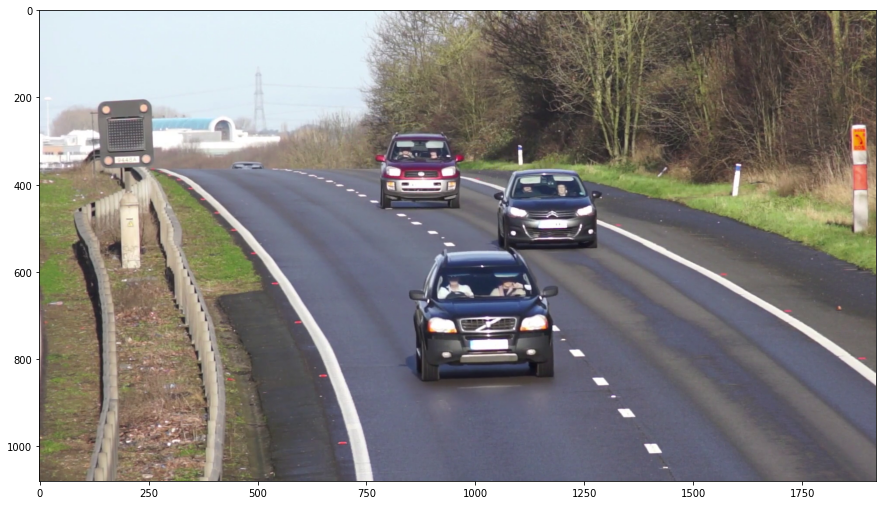

In [95]:
display_image(image)

In [96]:
image_with_detections = get_image_with_detections(image, boxes, classes)

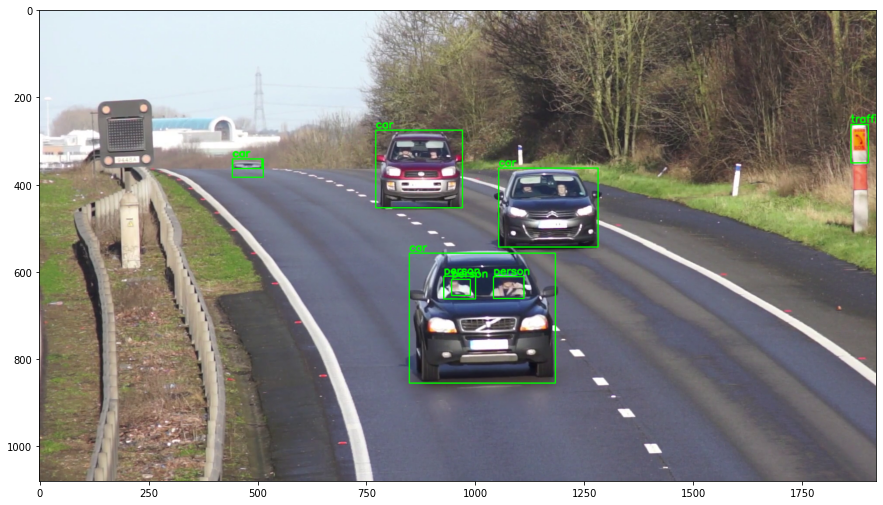

In [97]:
display_image(image_with_detections)

In [98]:
vehicle_boxes, vehicle_classes, vehicle_labels, vehicle_scores = get_vehicle_detections(VEHICLE_CLASSES,  boxes, classes, labels, scores)
image_with_vehicle_detections = get_image_with_detections(image, vehicle_boxes, vehicle_classes)

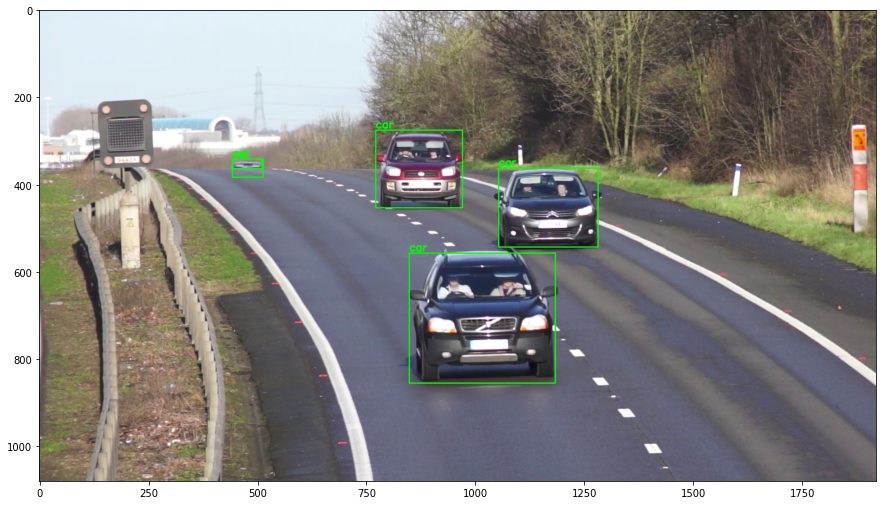

In [99]:
display_image(image_with_vehicle_detections)